In [1]:
import pandas as pd
import numpy as np

In [2]:
df = pd.read_csv('ml-100k/u.data', sep='\t', names=['user_id', 'item_id', 'rating', 'timestamp'])

In [9]:
len(df)

100000

In [40]:
df_movies = pd.read_csv('ml-10M100K/movies.dat',sep="::", names=["MovieID","Title","Genres"], engine='python')

In [42]:
df_movies.head()

,MovieID,Title,Genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [7]:
df_tags = pd.read_csv('ml-10M100K/tags.dat',sep="::", names=["UserID","MovieID","Tag","Timestamp"], engine='python')

In [79]:
df_ratings = pd.read_csv('ml-10M100K/ratings.dat',sep="::", names=["UserID","MovieID","Rating","Timestamp"], engine='python')

In [83]:
user_lyst = list(df_tags['UserID'].unique())

In [102]:
df_ratings = df_ratings[df_ratings['UserID'].isin(user_lyst)]

In [108]:
user_index = df_ratings.UserID.unique()
user_index.sort()

In [118]:
index_dict = {}
for i in range(len(user_index)):
    index_dict[user_index[i]] = i

In [137]:
item_index = df_ratings.MovieID.unique()
item_index.sort()

In [138]:
item_index_dict = {}
for i in range(len(item_index)):
    item_index_dict[item_index[i]] = i

### building train_data and user_item matrix

In [112]:
n_users = len(df_ratings.UserID.unique())

In [113]:
from sklearn import model_selection as cv

In [187]:
train_data, test_val_data = cv.train_test_split(df_ratings, test_size=0.25, random_state=42)
valid_data, test_data = cv.train_test_split(test_val_data, test_size=0.6, random_state=42)

In [193]:
user_item_matrix = np.zeros((n_users, n_items))
for row in train_data.itertuples():
    user_item_matrix[index_dict[row[1]], item_index_dict[row[2]]] = row[3]
    
test_data_matrix = np.zeros((n_users, n_items))
for row in test_data.itertuples():
    test_data_matrix[index_dict[row[1]], item_index_dict[row[2]]] = row[3]

In [194]:
from sklearn.metrics.pairwise import pairwise_distances

In [195]:
user_similarity = np.ones((n_users,n_users))-pairwise_distances(user_item_matrix, metric='cosine')

In [210]:
user_similarity.shape

(2320, 2320)

### Diffusion-Based Similarity

In [208]:
len(df_tags['Tag'].unique())

16529

In [285]:
df_tags.head()

,UserID,MovieID,Tag,Timestamp
0,15,4973,excellent!,1215184630
1,20,1747,politics,1188263867
2,20,1747,satire,1188263867
3,20,2424,chick flick 212,1188263835
4,20,2424,hanks,1188263835


In [256]:
sim_user_item = np.zeros((n_users, n_users))

In [257]:
for i, group in df_tags.groupby("MovieID"):
    length = len(group)
    for j in range(length-1):
        for k in range(j+1, length):         
            user1, user2 = group.iloc[j,0], group.iloc[k,0]
            if user1 in index_dict and user2 in index_dict:
                user1_index = index_dict[user1]
                user2_index = index_dict[user2]

                sim_user_item[user1_index][user2_index] += 1/length
                sim_user_item[user2_index][user1_index] += 1/length

### user tag matrix

In [258]:
sim_user_tag = np.zeros((n_users, n_users))

In [259]:
for i, group in df_tags.groupby("Tag"):
    length = len(group)
    for j in range(length-1):
        for k in range(j+1, length):         
            user1, user2 = group.iloc[j,0], group.iloc[k,0]
            if user1 in index_dict and user2 in index_dict:
                user1_index = index_dict[user1]
                user2_index = index_dict[user2]

                sim_user_tag[user1_index][user2_index] += 1/length
                sim_user_tag[user2_index][user1_index] += 1/length

In [228]:
user_degree_tags = df_tags.groupby("UserID").size()
for i in range(n_users):
    for j in range(n_users):
        if sim_user_tag[i][j]:
            degree_j = user_degree_tags[user_index[j]]
            sim_user_tag[i][j] /= degree_j
       
        if sim_user_item[i][j]:
            degree_j = user_degree_tags[user_index[j]]
            sim_user_item[i][j] /= degree_j

In [280]:
diffusion_based_similarity = 0.05*user_similarity + 0.95*sim_user_item

In [291]:
λ = [0.2,0.15,0.1,0.05,0.01]
rmse_diffusion_based = []
for h in λ:
    diffusion_based_similarity = h*user_similarity + (1-h)*sim_user_item
    diffusion_based_prediction = cf_predict(user_item_matrix, diffusion_based_similarity, type='user')
    rmse_diffusion_based.append(rmse(diffusion_based_prediction, test_data_matrix))

In [292]:
rmse_diffusion_based

[2.8738720443716015,
 2.8735847622165513,
 2.873108011239196,
 2.8720947278439724,
 2.8688815459115875]

In [298]:
from matplotlib import pyplot as plt

In [330]:
plt.rcParams["figure.figsize"] = (10,8)

In [339]:
df_tags.head()

,UserID,MovieID,Tag,Timestamp
0,15,4973,excellent!,1215184630
1,20,1747,politics,1188263867
2,20,1747,satire,1188263867
3,20,2424,chick flick 212,1188263835
4,20,2424,hanks,1188263835


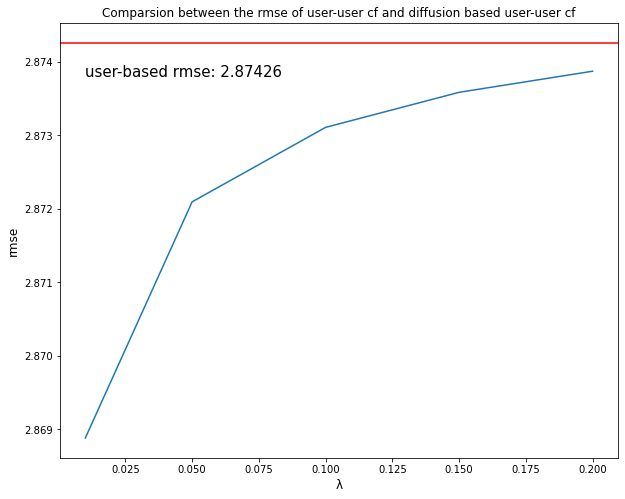

In [338]:
plt.plot(λ,rmse_diffusion_based)
plt.axhline(y = 2.87426, color = 'r', linestyle = '-')
plt.annotate("user-based rmse: 2.87426", xy=(0.01,2.8738), fontsize=15)

plt.xlabel("λ",fontsize=12)
plt.ylabel("rmse",fontsize=12)
plt.title("Comparsion between the rmse of user-user cf and diffusion based user-user cf", fontsize=12)
plt.savefig('diffusion_based_rmse.png')
plt.show()

In [337]:
plt.savefig('diffusion_based.png')

<Figure size 720x576 with 0 Axes>

In [281]:
def cf_predict(ratings, similarity, type='user'):
    if type == 'user':
        mean_user_rating = ratings.mean(axis=1)
        ratings_diff = (ratings - mean_user_rating[:, np.newaxis])
        pred = mean_user_rating[:, np.newaxis] + similarity.dot(ratings_diff) / np.array([np.abs(similarity).sum(axis=1)]).T
    elif type == 'item':
        pred = ratings.dot(similarity) / np.array([np.abs(similarity).sum(axis=1)])    
    return pred

In [282]:
user_based_prediction = cf_predict(user_item_matrix, user_similarity, type='user')

In [283]:
diffusion_based_prediction = cf_predict(user_item_matrix, diffusion_based_similarity, type='user')

In [278]:
from sklearn.metrics import mean_squared_error
from math import sqrt
def rmse(prediction, test_data_matrix):
    prediction = prediction[test_data_matrix.nonzero()].flatten()
    truth = test_data_matrix[test_data_matrix.nonzero()].flatten()
    return sqrt(mean_squared_error(prediction, truth))

In [284]:
print('rmse for user based collaborative: {}'.format(rmse(user_based_prediction, test_data_matrix)))
print('rmse for diffusion based collaborative: {}'.format(rmse(diffusion_based_prediction, test_data_matrix)))

rmse for user based collaborative: 2.874259156544976
rmse for diffusion based collaborative: 2.8720947278439724


In [342]:
len(df_tags['UserID'].unique())

4009